In [29]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


def bicubic(path):
    # defining function bicubic - 1 argument path
    # reads image

    width = image.shape[0]
    height = image.shape[1]

    scale = int(4)
    # the factor by which the image is to be scaled
    # size of output image after rescaling
    n_width = width * scale
    n_height = height * scale
    # extract's features of image
    im_rgb = []
    # an empty list
    B = np.array([[-1, 1, -1, 1], [0, 0, 0, 1], [1, 1, 1, 1], [8, 4, 2, 1]])
    # 4x4 bicubic kernel matrix B
    B_inv = np.linalg.inv(B)
    # Inverse of array B
    B_inv_T = B_inv.T
    # Transpose of B
    for i in range(3):
        # Iterating for each color channel
        channel_in = image[:, :, i]
        # assigning image shape to channel_in
        channel_out = np.zeros((n_width, n_height), dtype=np.uint8)
        # defining a 3d array of zeros with the resized width and height
        top_row = channel_in[0, :]
        bottom_row = channel_in[-1, :]
        image_row_padding = np.vstack((top_row, channel_in))
        image_row_padding = np.vstack((image_row_padding, bottom_row))
        image_row_padding = np.vstack((image_row_padding, bottom_row))
        # padding of top and bottom rows of the array are duplicated twice
        leftmost_column = image_row_padding[:, 0]
        rightmost_column = image_row_padding[:, -1]
        image_padding = np.c_[leftmost_column, image_row_padding, rightmost_column, rightmost_column]
        # leftmost and rightmost columns are duplicated once
        F = np.zeros((width, height, 4, 4))
        # below loop creates 4x4 array 'F' and it stores 16 nearest neighbour pixel for each pixel in input image
        for x in range(width):
            x_padding = x + 1
            for y in range(height):
                y_padding = y + 1
                f = np.array([[image_padding[x_padding - 1][y_padding - 1], image_padding[x_padding - 1][y_padding],
                               image_padding[x_padding - 1][y_padding + 1],
                               image_padding[x_padding - 1][y_padding + 2]],
                              [image_padding[x_padding][y_padding - 1], image_padding[x_padding][y_padding],
                               image_padding[x_padding][y_padding + 1], image_padding[x_padding][y_padding + 2]],
                              [image_padding[x_padding + 1][y_padding - 1], image_padding[x_padding + 1][y_padding],
                               image_padding[x_padding + 1][y_padding + 1],
                               image_padding[x_padding + 1][y_padding + 2]],
                              [image_padding[x_padding + 2][y_padding - 1], image_padding[x_padding + 2][y_padding],
                               image_padding[x_padding + 2][y_padding + 1],
                               image_padding[x_padding + 2][y_padding + 2]]])

                F[x][y] = f

        # below loop performs the actual bicubic interpolation
        # loops over the resized image width and height, computing the interpolated values at each point
        for x in range(n_width):
            # iterating resized width
            x_ori = (x / n_width) * width
            # calculating corresponding x position in original image
            x_interp = x_ori - np.floor(x_ori)
            # calculating difference produced of x interpolation
            x_int = int(np.floor(x_ori))
            # finding the nearest neighbour of x
            for y in range(n_height):
                # iterating resized height
                y_ori = (y / n_height) * height
                # calculating corresponding y position in original image
                y_interp = y_ori - np.floor(y_ori)
                # calculating difference produced of y interpolation
                y_int = int(np.floor(y_ori))

                if x_interp == 0.0 and y_interp == 0.0:
                    # check for out of bound
                    channel_out[x][y] = channel_in[int(x_ori)][int(y_ori)]
                else:
                    X = np.expand_dims(np.array([x_interp ** 3, x_interp ** 2, x_interp ** 1, x_interp ** 0]), axis=0)

                    Y = np.expand_dims(np.array([y_interp ** 3, y_interp ** 2, y_interp ** 1, y_interp ** 0]), axis=1)

                    F_interp = F[x_int][y_int]

                    interpolated_value = X.dot(B_inv).dot(F_interp).dot(B_inv_T).dot(Y)

                    if interpolated_value < 0:
                        interpolated_value = 0
                    elif interpolated_value > 255:
                        interpolated_value = 255

                    channel_out[x][y] = interpolated_value

        im_rgb.append(channel_out)

    im_rgb_out = cv2.merge((im_rgb[0], im_rgb[1], im_rgb[2]))
    print("Bicubic: // Completed//")

    return im_rgb_out


In [31]:
def psnr(img1, img2):
    mse = np.mean((np.array(img1) - np.array(img2)) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

In [38]:
from PIL import Image
import numpy as np

def crop_image(image, crop_coords):
    """
    Crop an image based on the provided coordinates and return the cropped image.
    :param image: NumPy array or PIL Image object representing the input image.
    :param crop_coords: Tuple (left, upper, right, lower) specifying the crop coordinates.
    :return: Cropped image as a NumPy array or PIL Image object.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    cropped_image = image.crop(crop_coords)
    return cropped_image

In [51]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

input_folder = "/content/drive/MyDrive/Master_Thesis/DATASET/test_dataset/Set14/LRbicx4/"
output_folder = "/content/drive/MyDrive/Master_Thesis/Bicubic_Interpolation/Results/Set14/"
original_folder = "/content/drive/MyDrive/Master_Thesis/DATASET/test_dataset/Set14/original/"
scale = 4
names = []
for image_name in os.listdir(input_folder):
    if image_name.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_folder, image_name)
        image = cv2.imread(image_path)

        scaled_image = bicubic(image)  # Apply bicubic interpolation
        names.append(image_name)
        output_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_path, scaled_image)

        original_image = cv2.resize(image, (scaled_image.shape[1], scaled_image.shape[0]))


Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//
Bicubic: // Completed//


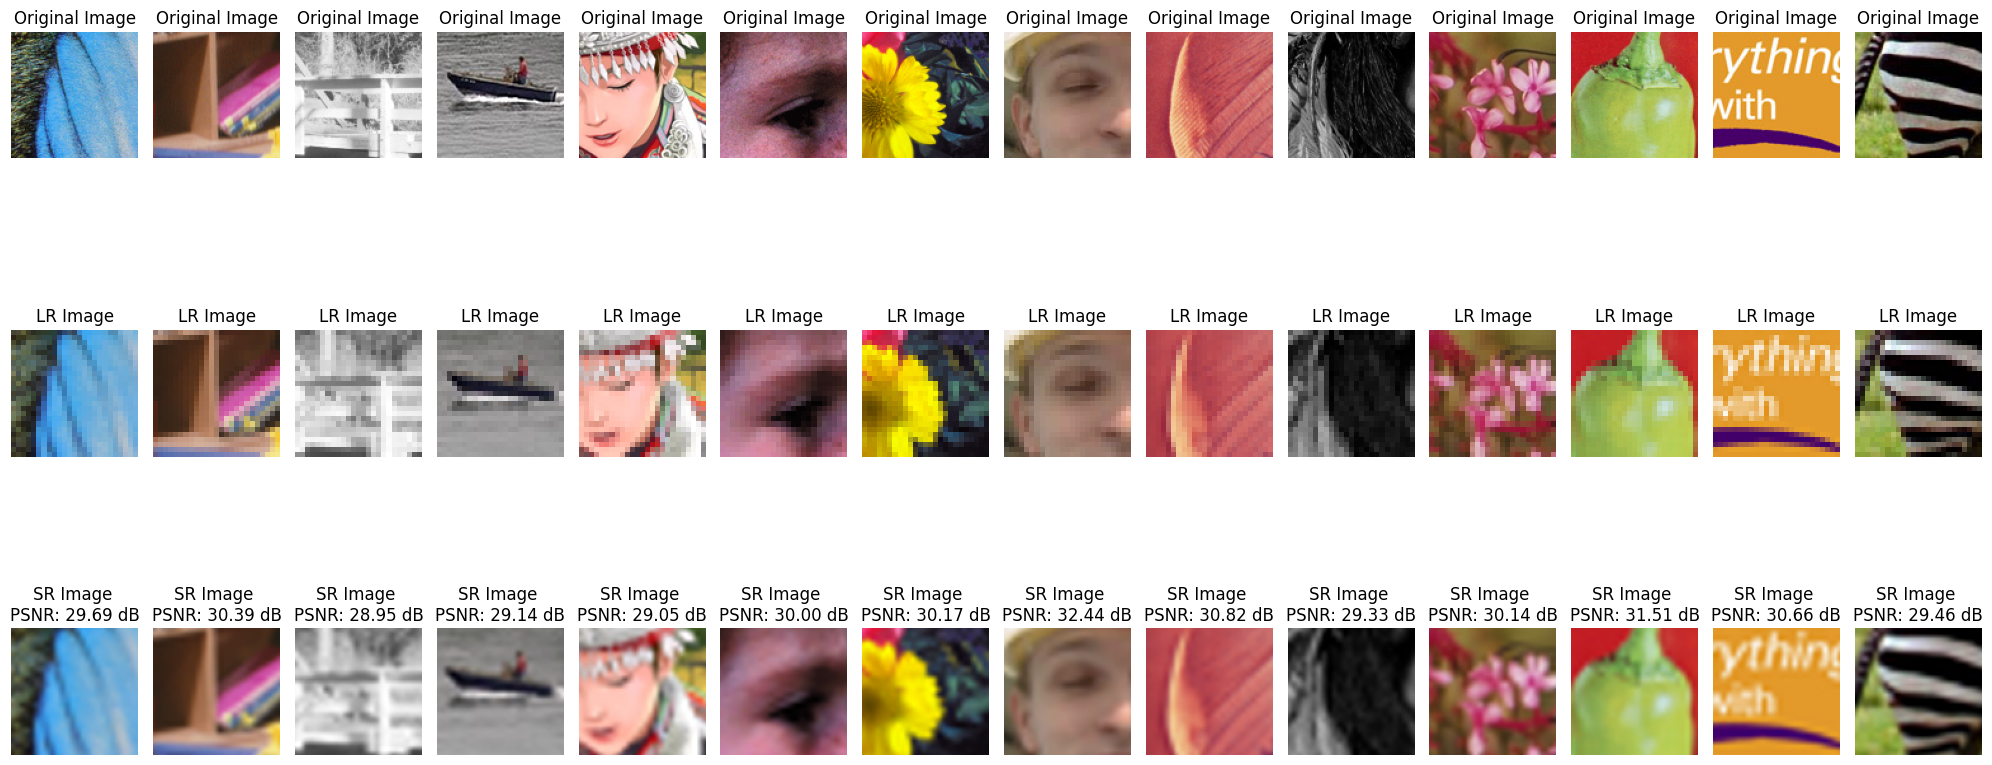

In [58]:
lr_crop_coords = (25, 25, 50, 50)
SR_HR_coords = (100,100,200,200)

fig, axes = plt.subplots(3, 14, figsize=(20, 10))

input_files = os.listdir(input_folder)
original_files = os.listdir(original_folder)
model_pred_files = os.listdir(output_folder)

input_files.sort()
original_files.sort()
model_pred_files.sort()

# Select only the first 14 images
input_files = input_files[:]
original_files = original_files[:]
model_pred_files = model_pred_files[1:]

psnr_dict={}

for i in range(len(input_files)):
    # Read the LR and HR images
    lr_img = cv2.imread(os.path.join(input_folder, input_files[i]))
    og_img = cv2.imread(os.path.join(original_folder, original_files[i]))
    sr_img = cv2.imread(os.path.join(output_folder, model_pred_files[i]))

    # Convert BGR to RGB for plotting
    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
    og_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
    sr_img = cv2.cvtColor(sr_img, cv2.COLOR_BGR2RGB)

    #Crop Images
    lr_img = crop_image(lr_img, lr_crop_coords)
    og_img = crop_image(og_img, SR_HR_coords)
    sr_img = crop_image(sr_img,SR_HR_coords)


    calculate_psnr = psnr(np.array(og_img),np.array(sr_img))
    psnr_dict[names[i]] = calculate_psnr

    # Plot the LR image
    axes[0, i].imshow(og_img)
    axes[0, i].set_title("Original Image")
    axes[0, i].axis("off")

    # Plot the HR image
    axes[1, i].imshow(lr_img)
    axes[1, i].set_title("LR Image")
    axes[1, i].axis("off")

    # Plot the HR image
    axes[2, i].imshow(sr_img)
    axes[2, i].set_title(f"SR Image \nPSNR: {calculate_psnr:.2f} dB")
    axes[2, i].axis("off")

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Master_Thesis/Bicubic_Interpolation/Results/Set14/Bicubic_x4_plot.jpg')


In [61]:
for i, (key, value) in enumerate(psnr_dict.items()):
    print(f"{i}: {key}: {value:.2f} dB")

0: baboon.png: 29.69 dB
1: barbara.png: 30.39 dB
2: bridge.png: 28.95 dB
3: coastguard.png: 29.14 dB
4: comic.png: 29.05 dB
5: face.png: 30.00 dB
6: flowers.png: 30.17 dB
7: foreman.png: 32.44 dB
8: lenna.png: 30.82 dB
9: man.png: 29.33 dB
10: monarch.png: 30.14 dB
11: pepper.png: 31.51 dB
12: ppt3.png: 30.66 dB
13: zebra.png: 29.46 dB
